In [81]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [82]:
# 2. Load and Prepare the Data
# Load your dataset (update the path accordingly)
file_path = "D:/NOTEBOOK/Modelling/e-commerce-scrubbed-data-filtered.xlsx"
df = pd.read_excel(file_path, usecols=['created_at', 'category_name_1', 'qty_ordered'])
df['created_at'] = pd.to_datetime(df['created_at'])
df['week'] = df['created_at'].dt.to_period('W').apply(lambda r: r.start_time)


In [83]:
# 3. Aggregate Weekly Orders
weekly = df.groupby(['category_name_1', 'week'])['qty_ordered'].count().reset_index()
pivot = weekly.pivot(index='week', columns='category_name_1', values='qty_ordered').fillna(0)
pivot.index = pd.to_datetime(pivot.index)

In [84]:
# 3A. 
# 1. Log Transform
pivot_log = np.log1p(pivot)

# 2. Handle Outliers
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df_clean

pivot_clean = remove_outliers(pivot_log, pivot_log.columns)

In [85]:
# 4. Split Data into Training and Testing
train_size = len(pivot_clean) - 6  # Last 6 weeks for testing
train_data = pivot_clean.iloc[:train_size]
test_data = pivot_clean.iloc[train_size:]

In [86]:
# 5. Normalize the Data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)  # Use the same scaler as training data

In [87]:
# 6. Create LSTM Sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 18
X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test, y_test = create_sequences(scaled_test, sequence_length)

In [88]:
# 7. Define and Train LSTM Model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
    Dense(3)
])
model.compile(optimizer='adam', loss='mse')
model.fit(
    X_train, 
    y_train, 
    epochs=100,           # More epochs for better learning
    batch_size=12,         # Larger batch size for stability
    verbose=1,            # Show progress
)

Epoch 1/100


d:\NOTEBOOK\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2927
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1894 
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0713 
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0412 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0453 
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0308 
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0382 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0372 
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0376 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0392 
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0323 
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0393 
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0346 
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0296 
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0322 
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━

In [89]:
# 8. Make Predictions
# For training data
train_predictions = model.predict(X_train)
train_predictions_rescaled = scaler.inverse_transform(train_predictions)
train_actual_rescaled = scaler.inverse_transform(y_train)

# For test data - use the last sequence_length weeks of training data to predict the first test week
last_sequence = scaled_train[-sequence_length:]
test_predictions = []
test_actual = scaled_test

# Make predictions for each test week
for i in range(len(test_data)):
    # Predict next week
    next_pred = model.predict(last_sequence.reshape(1, sequence_length, 3))
    test_predictions.append(next_pred[0])
    
    # Update sequence for next prediction
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1] = next_pred[0]

test_predictions = np.array(test_predictions)
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
test_actual_rescaled = scaler.inverse_transform(test_actual)

# Inverse log-transform (back to actual demand)
test_predictions_final = np.expm1(test_predictions_rescaled)
test_actual_final = np.expm1(test_actual_rescaled)
train_data_final = np.expm1(train_data)
test_data_final = np.expm1(test_data)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


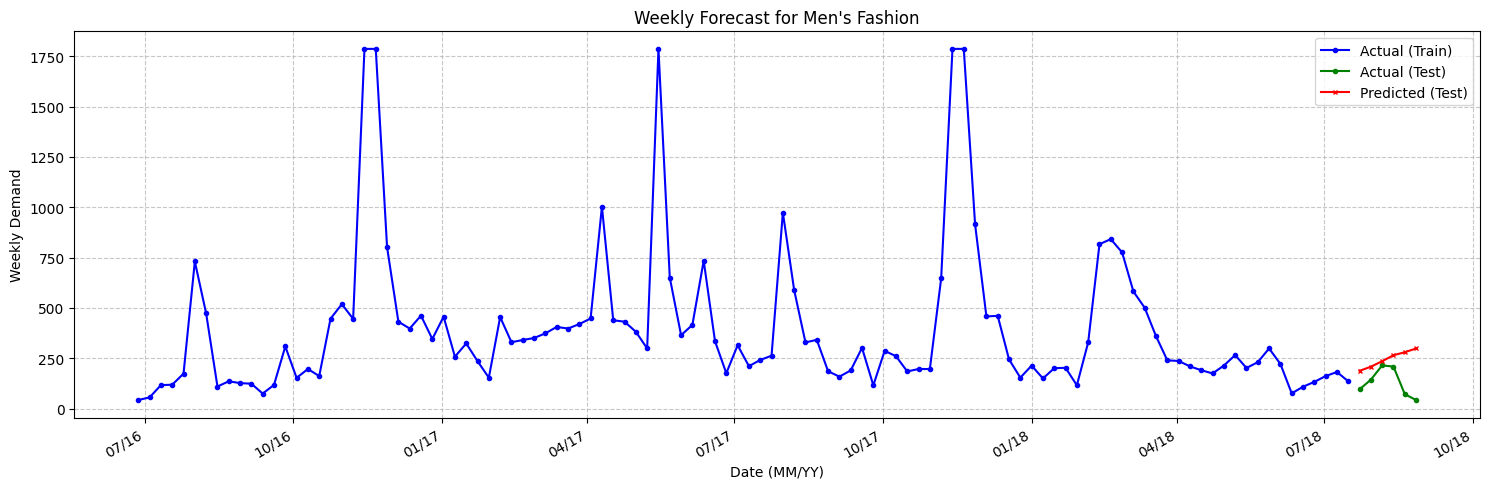

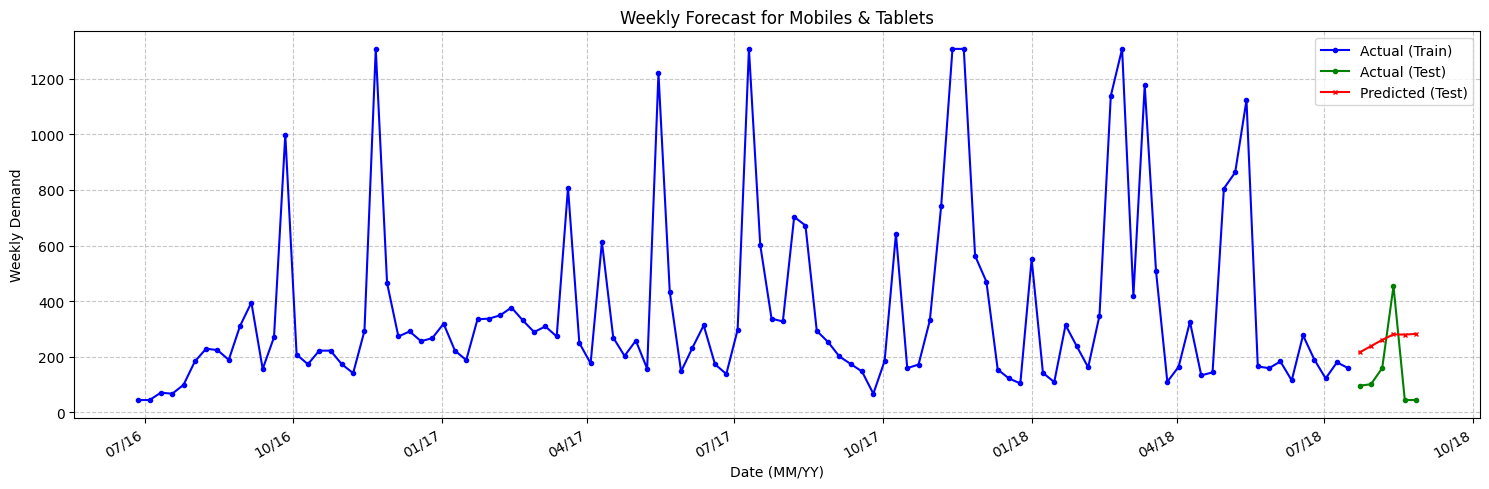

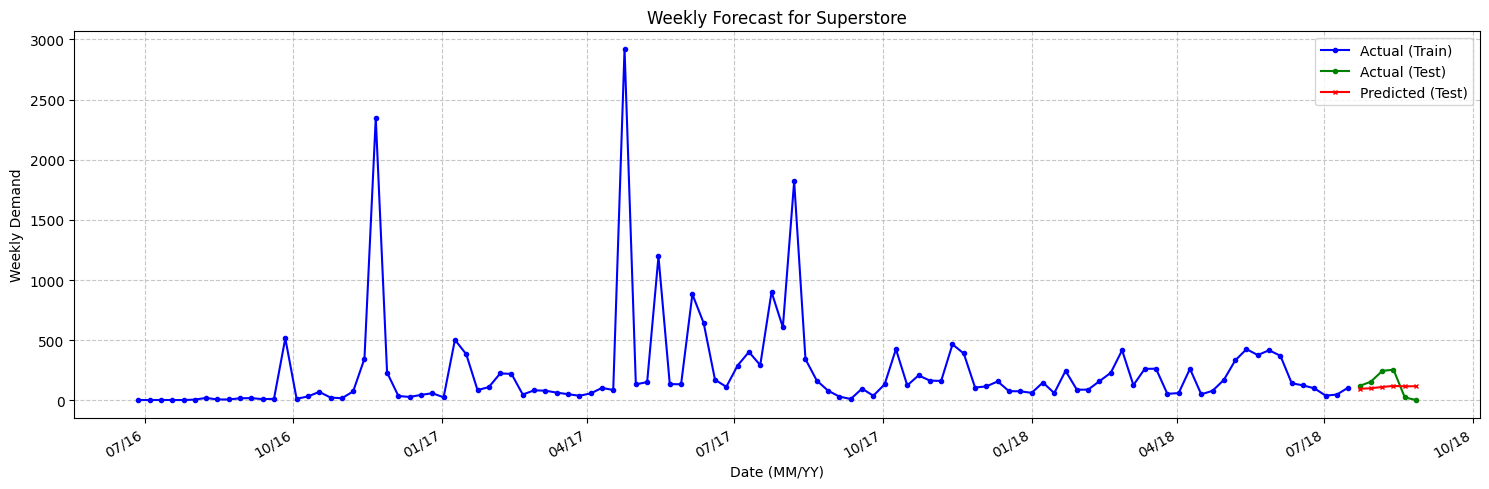

In [90]:
# 9. Plot Results
for i, cat in enumerate(pivot.columns):
    plt.figure(figsize=(15, 5))
    
    # Plot actual training data
    train_dates = train_data_final.index
    plt.plot(train_dates, train_data_final[cat], label='Actual (Train)', color='blue', marker='o', markersize=3)
    
    # Plot actual test data
    test_dates = test_data_final.index
    plt.plot(test_dates, test_actual_final[:, i], label='Actual (Test)', color='green', marker='o', markersize=3)
    
    # Plot predicted test data
    plt.plot(test_dates, test_predictions_final[:, i], label='Predicted (Test)', color='red', marker='x', markersize=3)
    
    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    plt.gcf().autofmt_xdate()
    
    plt.title(f"Weekly Forecast for {cat}")
    plt.xlabel("Date (MM/YY)")
    plt.ylabel("Weekly Demand")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [91]:
# 10. Calculate Metrics

# Define SMAPE function
def smape(actual, predicted):
    """
    Calculate SMAPE (Symmetric Mean Absolute Percentage Error)
    """
    return np.mean(2.0 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted))) * 100

# Create a DataFrame to store metrics
metrics_list = []

for i, cat in enumerate(pivot.columns):
    mae = mean_absolute_error(test_actual_final[:, i], test_predictions_final[:, i])
    rmse = np.sqrt(mean_squared_error(test_actual_final[:, i], test_predictions_final[:, i]))
    mask = test_actual_final[:, i] != 0
    if np.any(mask):
        mape = np.mean(np.abs((test_actual_final[:, i] - test_predictions_final[:, i]) / test_actual_final[:, i])) * 100
        smape_value = smape(test_actual_final[:, i], test_predictions_final[:, i])
    else:
        mape = np.nan
        smape_value = np.nan
    
    metrics_list.append({
        'Category': cat,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE': round(mape, 2) if not np.isnan(mape) else 'N/A',
        'SMAPE': round(smape_value, 2) if not np.isnan(smape_value) else 'N/A'
    })

# Create DataFrame from list
metrics_df = pd.DataFrame(metrics_list)

# Display metrics
print("\nError Metrics for Test Set:")
print(metrics_df.to_string(index=False))

# Calculate overall metrics
overall_mae = mean_absolute_error(test_data_final.values, test_predictions_final)
overall_rmse = np.sqrt(mean_squared_error(test_data_final.values, test_predictions_final))

# Calculate overall MAPE and SMAPE
# Convert to numpy arrays and flatten
test_data_flat = test_data_final.values.flatten()
test_pred_flat = test_predictions_final.flatten()

# Calculate MAPE and SMAPE only for non-zero actual values
mask = test_data_flat != 0
if np.any(mask):
    overall_mape = np.mean(np.abs((test_data_flat[mask] - test_pred_flat[mask]) / test_data_flat[mask])) * 100
    overall_smape = smape(test_data_flat, test_pred_flat)
else:
    overall_mape = np.nan
    overall_smape = np.nan

print("\nOverall Error Metrics for Test Set:")
print(f"Overall MAE: {round(overall_mae, 2)}")
print(f"Overall RMSE: {round(overall_rmse, 2)}")
print(f"Overall MAPE: {round(overall_mape, 2) if not np.isnan(overall_mape) else 'N/A'}%")
print(f"Overall SMAPE: {round(overall_smape, 2) if not np.isnan(overall_smape) else 'N/A'}%")

# Print interpretation of metrics
print("\nInterpretation:")
print("MAE: Average absolute difference between predicted and actual values")
print("RMSE: Square root of average squared differences (penalizes larger errors more)")
print("MAPE: Average percentage difference between predicted and actual values")
print("SMAPE: Symmetric Mean Absolute Percentage Error (handles zero values and treats over/under predictions equally)")


Error Metrics for Test Set:
         Category    MAE   RMSE   MAPE  SMAPE
    Men's Fashion 116.39 144.49 177.32  67.09
Mobiles & Tablets 167.50 175.84 238.26  90.70
       Superstore  92.28 101.03 659.40  88.22

Overall Error Metrics for Test Set:
Overall MAE: 125.39
Overall RMSE: 143.76
Overall MAPE: 358.33%
Overall SMAPE: 82.0%

Interpretation:
MAE: Average absolute difference between predicted and actual values
RMSE: Square root of average squared differences (penalizes larger errors more)
MAPE: Average percentage difference between predicted and actual values
SMAPE: Symmetric Mean Absolute Percentage Error (handles zero values and treats over/under predictions equally)
